# Validate Plain

In [98]:
import os
from pathlib import Path
SCRIPT_DIR = os.path.dirname(os.path.abspath("__init__.py"))
SRC_DIR = Path(SCRIPT_DIR).parent.absolute()
print(SRC_DIR)

/Users/yannis/PycharmProjects/WeRec3D/src


In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import pandas as pd
import numpy as np

from plotting import display_predictions

In [101]:
FULL_PRED_FILE = "predictions/full_pred_plain.npy"

In [102]:
DATES = pd.date_range('1807-01-01', freq='D', periods=365).values
DATES = list(map(lambda d: str(d).split('T')[0], DATES))
def date_to_id(date):
    return DATES.index(date)

## Full

In [103]:
pred = np.load(FULL_PRED_FILE)
pred.shape

(365, 32, 64, 2)

In [104]:
# Convert to hecto pascal
pred[...,1] = pred[...,1] /100
pred.shape

(365, 32, 64, 2)

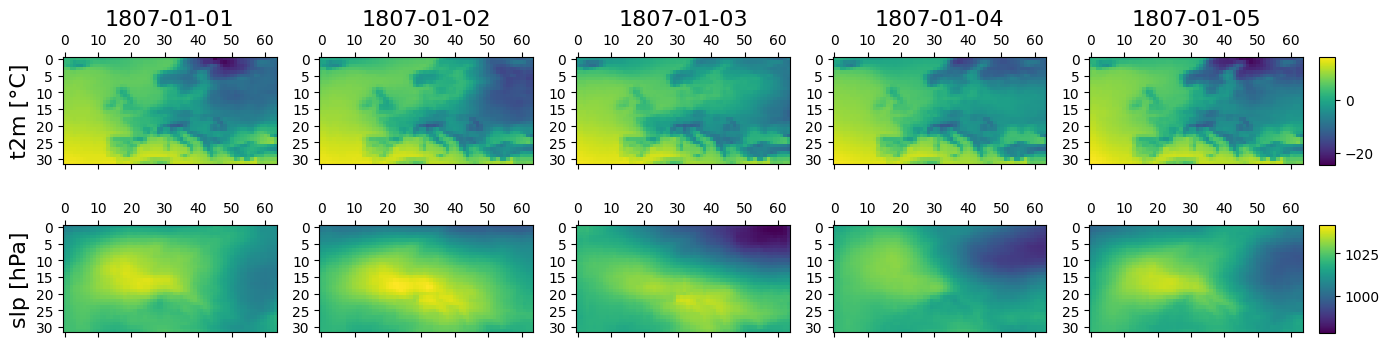

In [105]:
date = "1807-01-01"
day_id = date_to_id(date)
fig = display_predictions(pred, day_id,date)

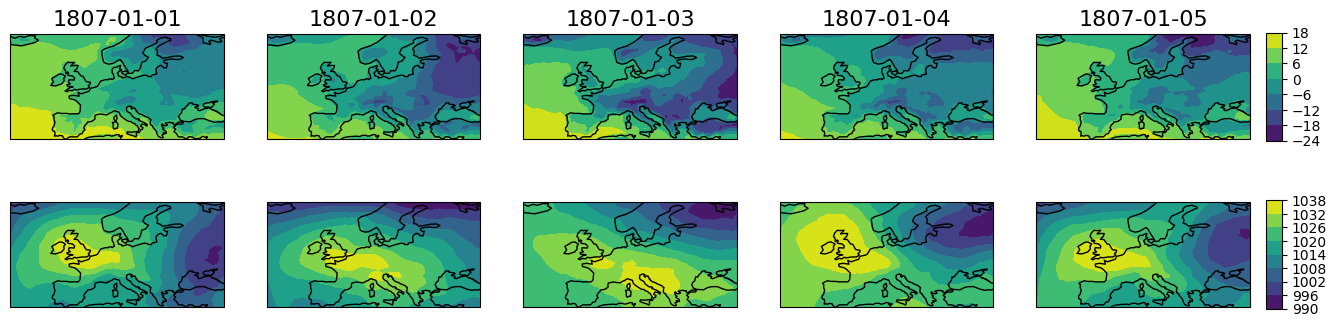

In [106]:
fig = display_predictions(pred, day_id,date, show_contours=True)

## LOO

In [107]:
import xarray as xr

from data_transformer import extract_stations_from_nc
from data_provider import get_station_indices_map

from taylor_helpers import get_nan_ids, extract_anomalies, get_loo_taylor_metrics
from plotting import create_normed_taylor_diagram

In [108]:
GROUND_TRUTH = "data_sets/ground_truth.nc"
LOO_PRED_FILE = "predictions/loo_pred_plain.nc"

In [109]:
station_indx_map = get_station_indices_map()
ground_truth = xr.load_dataset(GROUND_TRUTH)
gt_stations = extract_stations_from_nc(ground_truth, station_indx_map)  # Is scaled.

loo_pred = xr.load_dataset(LOO_PRED_FILE)
pred_stations = extract_stations_from_nc(loo_pred, station_indx_map)

In [110]:
missing_indicies = get_nan_ids(gt_stations)

anomaly_pred_stations = extract_anomalies(pred_stations, station_indx_map)                  # Pred has no NaNs
anomaly_gt_stations = extract_anomalies(gt_stations, station_indx_map, missing_indicies)    # GT has NaNs
taylor_metrics = get_loo_taylor_metrics(anomaly_gt_stations, anomaly_pred_stations, missing_indicies)

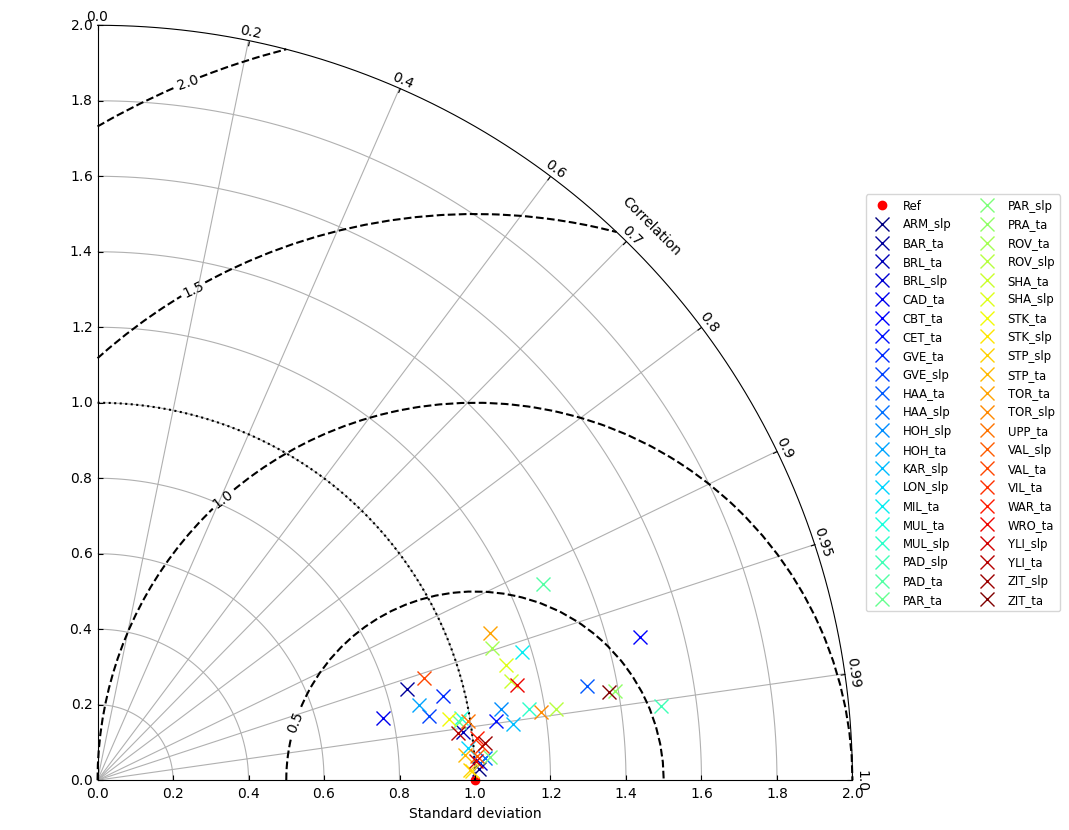

In [111]:
fig = create_normed_taylor_diagram(ref_std=1,
                                   test_std_devs=[m['norm_std'] for m in taylor_metrics.values()],
                                   test_corrs=[m['corr'] for m in taylor_metrics.values()],
                                   labels=list(taylor_metrics.keys()),
                                   )

fig.savefig(f"figures/taylor_loo_plain.png", bbox_inches='tight', pad_inches=0.1)

In [112]:
taylor_df = pd.DataFrame(taylor_metrics)

print(f"Min Corr: {taylor_df.loc['corr'].min()}")
print(f"Max normed-StdDev Delta: {max(abs(taylor_df.loc['norm_std'].max()-1), abs(1-taylor_df.loc['norm_std'].min()))}")
print(f"Max normed-RMSE: {taylor_df.loc['norm_rmse'].max()}")

Min Corr: 0.9147221526057756
Max normed-StdDev Delta: 0.505189667002115
Max normed-RMSE: 0.5794111468338397


In [113]:
taylor_df

,ARM_slp,BAR_ta,BRL_ta,BRL_slp,CAD_ta,CBT_ta,CET_ta,GVE_ta,GVE_slp,HAA_ta,...,UPP_ta,VAL_slp,VAL_ta,VIL_ta,WAR_ta,WRO_ta,YLI_slp,YLI_ta,ZIT_slp,ZIT_ta
corr,0.999559,0.958993,0.991511,0.999016,0.977200,0.966758,0.988994,0.971752,0.981549,0.982086,...,0.987259,0.997949,0.954322,0.996121,0.993809,0.975388,0.998683,0.991389,0.995467,0.985310
norm_std,1.012129,0.855028,0.977747,1.013374,0.775130,1.486698,1.067343,0.942578,0.893396,1.320785,...,0.993403,1.006159,0.905149,1.023703,1.012844,1.138444,1.004312,0.963609,1.031884,1.373933
norm_rmse,0.032246,0.301895,0.130751,0.046623,0.293109,0.579411,0.167418,0.237802,0.210554,0.387587,...,0.159241,0.064535,0.302800,0.092211,0.112717,0.274237,0.051613,0.133864,0.101836,0.424491


### RMSE on LOO (non normalized)

In [114]:
rmse_stations_ta = []
rmse_stations_slp = []

for station_id in gt_stations.keys():
    pred = pred_stations[station_id]
    gt = gt_stations[station_id]
    if missing_indicies[station_id]:
        pred = np.delete(pred, missing_indicies[station_id])
        gt = np.delete(gt, missing_indicies[station_id])
    
    rmse_station = np.sqrt(np.mean(np.square(gt - pred)))
    if "_ta" in station_id:
        rmse_stations_ta.append(rmse_station)
    else:
        rmse_stations_slp.append(rmse_station)

print(np.mean(rmse_stations_ta))
print(np.mean(rmse_stations_slp))
    

1.7085489128599858
136.85835141175446


## Time Series: Best / Worst LOO (TA only?)

In [115]:
import pandas as pd

In [116]:
metrics_df = pd.DataFrame(taylor_metrics)
ta_only_cols = list(filter(lambda x: "_ta" in x, metrics_df.columns))
metrics_df = metrics_df[ta_only_cols]

worst_station = metrics_df.idxmax(axis=1)['norm_rmse']
best_station = metrics_df.idxmin(axis=1)['norm_rmse']
print(f"Worst station: {worst_station}")
print(f"Best station: {best_station}")

best_rmse = metrics_df.loc['norm_rmse'][best_station].round(3)
worst_rmse = metrics_df.loc['norm_rmse'][worst_station].round(3)
print(best_rmse, worst_rmse)

print(metrics_df.loc['norm_rmse'][[worst_station, best_station]])

Worst station: CBT_ta
Best station: STP_ta
0.071 0.579
CBT_ta    0.579411
STP_ta    0.070925
Name: norm_rmse, dtype: float64


In [117]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
CITIES = {'CBT': 'Central Belgium', 'STK': 'Stockholm', "STP": 'St. Petersburg'}

def create_station_line_plot(best_pred, best_gt, best_stat_id, worst_pred, worst_gt, worst_stat_id, save_file_path=None):

    fig, axs = plt.subplots(2, 1, figsize=(16, 11))

    if "_slp" in best_stat_id:
        # Convert to hPa
        best_pred = best_pred / 100
        best_gt = best_gt / 100
    if "_slp" in worst_stat_id:
        # Convert to hPa
        worst_pred = worst_pred / 100
        worst_gt = worst_gt / 100

    date_range = pd.date_range('1807-01-01', freq='D', periods=365)

    best_pred_df = pd.DataFrame({'vals': best_pred, 'dates': date_range})
    best_gt_df = pd.DataFrame({'vals': best_gt, 'dates': date_range})

    best_station_name = CITIES[best_stat_id.split('_')[0]]
    best_title_addon = "Temperature" if "_ta" in best_stat_id else "Pressure"
    axs[0].set_title(best_station_name + " " + best_title_addon)

    axs[0].plot('dates', 'vals', data=best_pred_df, color='red', label="Reconstruction")
    axs[0].plot('dates', 'vals', data=best_gt_df, color='blue', label="Station observation")

    axs[0].set_ylabel("ta [°C]" if "_ta" in best_stat_id else "slp [hPa]")
    # axs[0].set_xlabel("Year 1807")

    axs[0].grid(True)
    axs[0].legend()

    # Major ticks every half year, minor ticks every month,
    axs[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    axs[0].xaxis.set_minor_locator(mdates.MonthLocator())
    
    
    worst_pred_df = pd.DataFrame({'vals': worst_pred, 'dates': date_range})
    worst_gt_df = pd.DataFrame({'vals': worst_gt, 'dates': date_range})
    
    worst_station_name = CITIES[worst_stat_id.split('_')[0]]
    worst_title_addon = "Temperature" if "_ta" in worst_stat_id else "Pressure"
    axs[1].set_title(worst_station_name + " " + worst_title_addon)

    axs[1].plot('dates', 'vals', data=worst_pred_df, color='red', label="Reconstruction")
    axs[1].plot('dates', 'vals', data=worst_gt_df, color='blue', label="Station observation")

    axs[1].set_ylabel("ta [°C]" if "_ta" in worst_stat_id else "slp [hPa]")
    # axs[1].set_xlabel("Year 1807")

    axs[1].grid(True)
    axs[1].legend()
    
    if save_file_path:
        plt.savefig(save_file_path, bbox_inches='tight', pad_inches=0.1)

    return fig

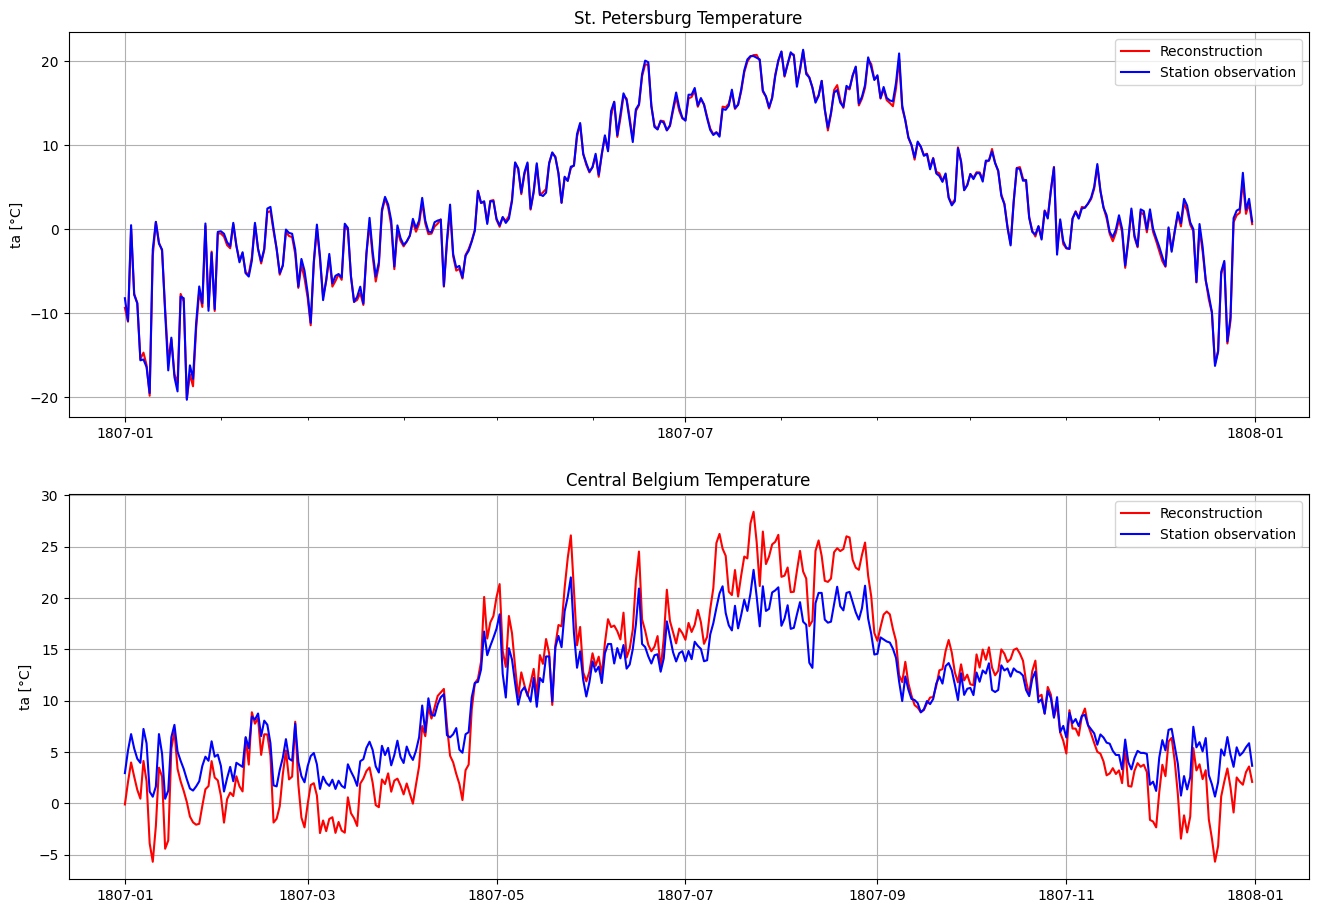

In [118]:
fig = create_station_line_plot(best_pred=pred_stations[best_station],
                               best_gt=gt_stations[best_station],
                               best_stat_id=best_station,
                               worst_pred=pred_stations[worst_station],
                               worst_gt=gt_stations[worst_station],
                               worst_stat_id=worst_station,
                               save_file_path="figures/best_worst_time_series.png"
                            )

## Average highest temperature according to GT

In [122]:
pred = np.load(FULL_PRED_FILE)
pred.shape

(365, 32, 64, 2)

In [123]:
temp_df = pd.DataFrame(gt_stations)
temp_df = temp_df[list(filter(lambda c: "_ta" in c,  temp_df.columns))]
temp_df

,BAR_ta,BRL_ta,CAD_ta,CBT_ta,CET_ta,GVE_ta,HAA_ta,HOH_ta,MIL_ta,MUL_ta,...,STK_ta,STP_ta,TOR_ta,UPP_ta,VAL_ta,VIL_ta,WAR_ta,WRO_ta,YLI_ta,ZIT_ta
0,8.173404,-0.563522,13.351880,2.943470,2.762760,-1.150457,4.278225,-7.460374,0.520725,-0.164513,...,-8.546094,-8.225457,1.005886,-8.879925,9.336709,-10.271156,-4.691815,0.051106,-23.766886,-2.066512
1,8.573404,1.736478,13.051880,5.143470,-0.537240,-2.450457,5.478225,-8.260374,1.420725,-3.964513,...,0.853906,-10.925457,-0.094114,0.720075,11.536709,-8.471156,-3.891815,-0.448894,-3.766886,-0.566512
2,6.173404,3.836478,13.651880,6.743470,2.262760,-4.150457,6.978225,-4.360374,0.820725,-4.264513,...,1.653906,0.474543,-0.194114,3.120075,11.536709,0.528844,0.708185,0.451106,-3.466886,-0.866512
3,6.973404,-0.063522,12.551880,5.343470,4.462760,-4.650457,5.178225,-5.360374,0.020725,-1.764513,...,-4.046094,-7.825457,-0.394114,-5.879925,10.036709,-0.971156,-3.391815,-0.548894,-10.166886,-1.066512
4,5.873404,-1.763522,10.251880,4.343470,3.262760,-0.450457,4.578225,-8.360374,1.420725,-3.164513,...,-8.046094,-8.825457,-0.094114,-10.379925,10.036709,-9.471156,-3.891815,-4.148894,-22.166886,-2.366512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,5.478523,1.924340,8.867432,4.654959,7.026526,-6.678991,4.619635,-2.077580,-2.065587,-3.579882,...,3.389946,2.411673,-4.184982,2.659278,NaN,1.008317,0.487466,0.967452,-12.579498,-1.779514
361,6.178523,1.424340,8.167432,4.954959,5.526526,-0.578991,4.219635,-4.577580,-1.465587,-0.879882,...,3.089946,6.711673,-3.084982,3.659278,10.633584,0.408317,0.487466,-0.832548,-8.179498,-2.879514
362,5.978523,2.224340,10.067432,5.454959,7.826526,-5.278991,5.719635,1.922420,-2.665587,-1.079882,...,3.789946,2.311673,-3.684982,4.159278,10.933584,0.408317,-0.112534,-0.332548,-14.579498,-3.279514
363,6.078523,0.624340,8.467432,5.854959,6.526526,-6.978991,4.819635,-0.377580,-3.465587,0.020118,...,4.289946,3.611673,-4.584982,4.559278,10.933584,-0.791683,-1.112534,0.167452,-6.179498,-2.979514


In [124]:
temp_df.mean(axis=1).argmax()

211

1807-07-31


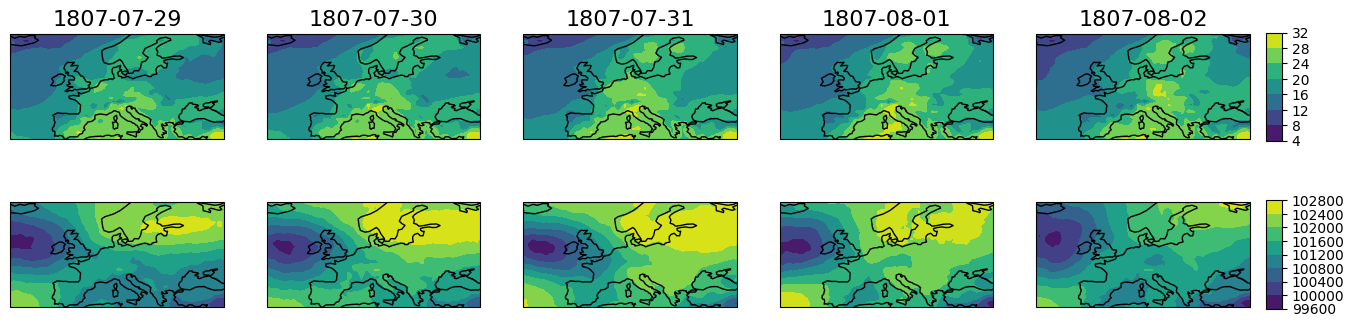

In [125]:
avg_max_id = 211
avg_max_date = DATES[avg_max_id]
print(avg_max_date)

mid_id = avg_max_id - 2
mid_date = DATES[mid_id]

fig = display_predictions(pred, mid_id, mid_date, True)
plt.savefig("figures/hottest_gt_day.png", bbox_inches='tight', pad_inches=0.1)